# <u>Multivariate Outlier Detection in Geochemical Datasets</u>

This notebook is intended as an open-source resource for exploring, analyzing and comparing three different methods of outlier detection in geochemical datasets in the context of mineral exploration.  
<br />
<br />
The three primary outlier detection algorithms we will use are the following: 
- Isolation Forests (IF) (Liu et al., 2008)
- Local Outlier Factor (LOF) (Breunig et al., 2000)
- Angle Based Outlier Detection (ABOD) (Shahrestani & Sanislav, 2025)
<br />
<br />

This work is driven from the findings in Antoine Caté's article on multivariate outlier detection for mineral exploration.

<br />
<br />
<u>References: </u>

*Breunig, M. M., Kriegel, H.-P., Ng, R. T., and Sander, J., 2000, LOF: Identifying Density-Based Local Outliers: ACM SIGMOD Record, v. 29, no. 2, p. 93-104.*

*Liu, F. T., Ting, K. M., and Zhou, Z.-H., 2008, Isolation Forest, 2008 Eighth IEEE International Conference on Data Mining, p. 413-422.*

*Maklin, C., 2022, Isolation Forest - Cory Maklin - Medium: Medium, https://medium.com/@corymaklin/isolation-forest-799fceacdda4.*

*Shahrestani, S., and Sanislav, I., 2025, Mapping geochemical anomalies using angle-based outlier detection approach: Journal of Geochemical Exploration, v. 269.*
<br />

---

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree
from sklearn.metrics import roc_auc_score
from scipy.stats import f_oneway
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve, auc

*For the testing of these algorithms we are going to use geochemical data from a region in southwestern Saudi Arabia. All units are converted to ppm for consistency.*

In [2]:
# Import and preview the data, create a copy of the data with only numeric columns
data_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/KSA Data/KSA_GSAS_data.csv"
df = pd.read_csv(data_filepath)
print(df.head(3))

  Sample Field Number  Longitude   Latitude       Br      Cl     Cr       Hf  \
0         421911AD001  42.772083  19.993880  1.41950  62.743  47.29  3.49742   
1         421911AD002  42.778492  19.996819  2.13468  28.329  52.81  4.82120   
2         421911AD003  42.814612  19.982057  1.89862  31.059  35.74  5.69027   

         P      Rb        Ti  ...      Sb      Se        Ag         B  \
0  759.625  41.156  3307.385  ...  0.4220  0.2038  0.036737  16.64191   
1  828.342  45.921  4517.659  ...  0.8238  0.1229  0.045773  12.55748   
2  769.358  50.198  5789.542  ...  1.2301  0.1830  0.050043  12.21876   

         Sn      F       N      S      TC      LOI  
0  1.402524  487.1   89.39  124.6  6725.0  38100.0  
1  1.902777  442.5   86.80   62.2  4647.0  35300.0  
2  2.071384  521.3  127.60   66.3  6186.0  39100.0  

[3 rows x 60 columns]


In [3]:
# Define plotting function
def plot_outlier_results(
    data: pd.DataFrame,
    x_col: str,
    y_col: str,
    score_col: str,
    binary_col: str,
    point_size: float = 100,
    score_title: str = "Anomaly Score",
    binary_title: str = "Binary Classification",
    plot_title: str = "Outlier Detection Results",
    cmap: str = "coolwarm",
    binary_colors: dict = None,
):
    """
    Plot the results of outlier detection with a score-based heatmap and binary classification.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing geospatial and outlier information.
    - x_col (str): Column name for x-axis (e.g., 'Longitude').
    - y_col (str): Column name for y-axis (e.g., 'Latitude').
    - score_col (str): Column name for continuous anomaly scores.
    - binary_col (str): Column name for binary classification (-1 for outliers, 1 for inliers).
    - point_size (float): Size of the points in the scatter plots (default: 100).
    - score_title (str): Title for the score-based plot (default: "Anomaly Score").
    - binary_title (str): Title for the binary plot (default: "Binary Classification").
    - plot_title (str): Title for the entire figure (default: "Outlier Detection Results").
    - cmap (str): Colormap for the score plot (default: "coolwarm").
    - binary_colors (dict): Optional custom color map for binary classification
                            (default: {1: "blue", -1: "red"}).
    """
    # Default binary colors if not provided
    if binary_colors is None:
        binary_colors = {1: "blue", -1: "red"}

    # Check if required columns exist in the data
    for col in [x_col, y_col, score_col, binary_col]:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the data.")

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # Plot the score-based heatmap
    sc1 = axes[0].scatter(
        data[x_col],
        data[y_col],
        c=data[score_col],
        cmap=cmap,
        s=point_size,  # Use point_size here
    )
    cbar1 = fig.colorbar(sc1, ax=axes[0])
    cbar1.set_label(score_title, fontsize=12)
    axes[0].set_title(score_title, fontsize=14)
    axes[0].set_xlabel(x_col, fontsize=12)
    axes[0].set_ylabel(y_col, fontsize=12)
    axes[0].grid(True)

    # Plot the binary classification
    axes[1].scatter(
        data[x_col],
        data[y_col],
        c=data[binary_col].map(binary_colors),
        s=point_size,  # Use point_size here
        label="Inliers/Outliers",
    )
    axes[1].set_title(binary_title, fontsize=14)
    axes[1].set_xlabel(x_col, fontsize=12)
    axes[1].set_ylabel(y_col, fontsize=12)
    axes[1].grid(True)

    # Add a legend for binary classification
    legend_labels = {
        1: "Inlier",
        -1: "Outlier",
    }
    handles = [
        plt.Line2D(
            [0], [0], marker="o", color="w", markerfacecolor=color, markersize=10
        )
        for value, color in binary_colors.items()
    ]
    labels = [legend_labels.get(value, str(value)) for value in binary_colors.keys()]
    axes[1].legend(handles, labels, loc="upper right", fontsize=12)

    # Set the overall plot title
    plt.suptitle(plot_title, fontsize=18)
    plt.show()

### <u>Isolation Forests</u>

Isolation forests are an unsupervised machine learning method of outlier/anomaly detection. It is an ensemble method that combines the predictions of several decision trees to assign an anomaly score to a given data point. Samples that require fewer splits across all trees are given a lower anomaly score (higher likelihood of being anomalous). This method of outlier detection is not affected by data distribution, but does require some parameter-tuning. 

In [4]:
def isolation_forest(
    data: pd.DataFrame,
    feature_columns: list = None,
    contamination: float = 0.05,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Detect outliers in a geochemical dataset using the Isolation Forest algorithm.

    Parameters:
    - data (pd.DataFrame): The input geochemical dataset.
    - feature_columns (list): List of column names to be used as features.
                              If None, all numerical columns will be used.
    - contamination (float): The proportion of outliers in the dataset (default: 0.05).
    - random_state (int): Random seed for reproducibility (default: 42).

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]:
        1. DataFrame with additional columns:
            - 'outlier': Binary classification (-1 = outlier, 1 = inlier).
            - 'anomaly_score': Continuous anomaly score (lower = more anomalous).
        2. DataFrame containing only the detected outliers.
    """
    # Make a copy of the input DataFrame to avoid modifying the original
    data_copy = data.copy()

    # Validate inputs
    if not isinstance(data_copy, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")

    # Use all numerical columns if feature_columns is None
    if feature_columns is None:
        feature_columns = data_copy.select_dtypes(include=[np.number]).columns.tolist()
        if not feature_columns:
            raise ValueError(
                "No numerical columns found in the dataset to use as features."
            )

    if not all(col in data_copy.columns for col in feature_columns):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not 0 < contamination < 0.5:
        raise ValueError("Contamination must be between 0 and 0.5.")

    # Prepare the data
    features = data_copy[feature_columns].copy()

    # Handle missing values by imputing with column mean
    if features.isnull().values.any():
        features = features.fillna(features.mean())

    # Initialize and fit the Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    iso_forest.fit(features)

    # Add the binary classification to the copied DataFrame
    data_copy["outlier"] = iso_forest.predict(features)

    # Add the continuous anomaly scores to the copied DataFrame
    data_copy["anomaly_score"] = iso_forest.decision_function(features)

    # Separate outliers based on binary classification
    outliers = data_copy[data_copy["outlier"] == -1]

    return data_copy, outliers

In [5]:
# Run the function
feature_columns = ['Br', 'Cl', 'Cr', 'Hf',
       'P', 'Rb', 'Ti', 'Zr', 'SiO2', 'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn',
       'Sr', 'V', 'Zn', 'MgO', 'CaO', 'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu',
       'Ga', 'In', 'Li', 'Mo', 'Nb', 'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I',
       'Ta', 'W', 'Re', 'Au', 'Ir', 'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se',
       'Ag', 'B', 'Sn', 'F', 'N', 'S', 'TC', 'LOI'] # List of all geochemical columns

IF_df, IF_outliers = isolation_forest(
    df, feature_columns, contamination=0.1
)

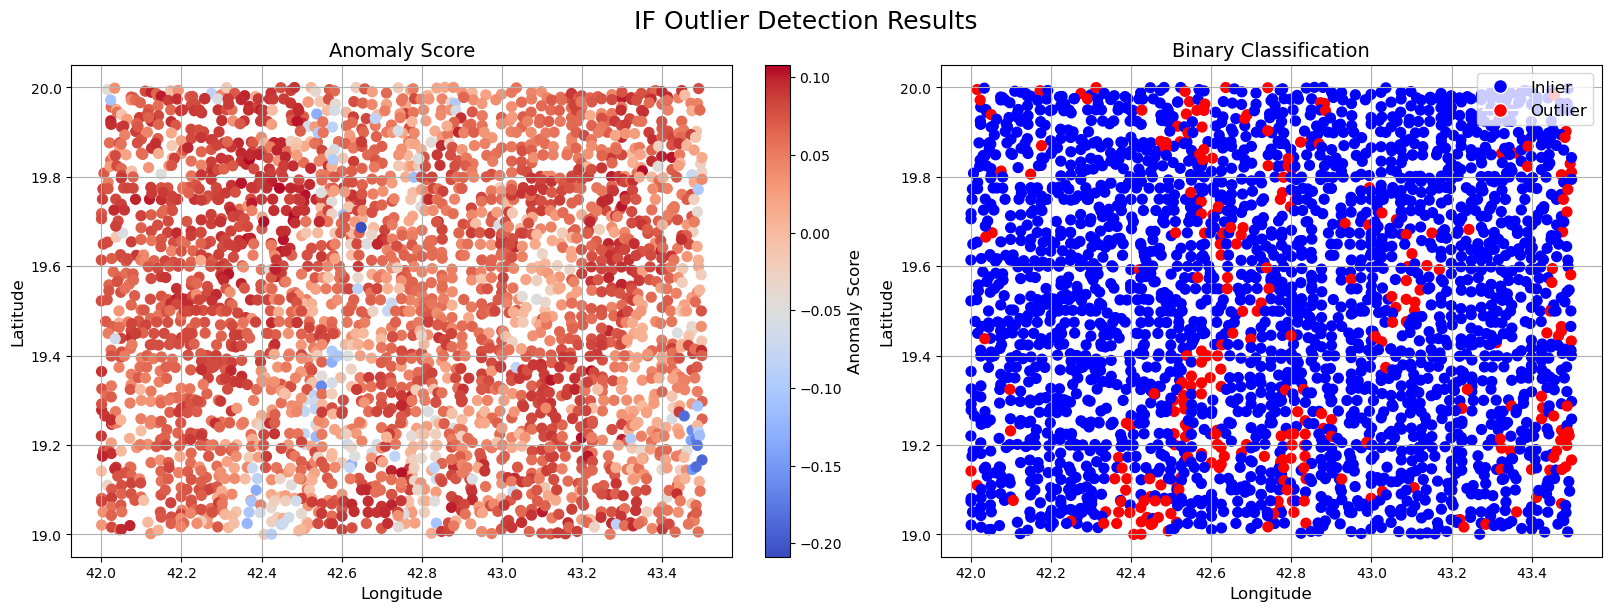

In [6]:
# Plotting IF results
plot_outlier_results(
    data=IF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="IF Outlier Detection Results",
)

Remember that lower anomaly scores for IF indicate a *higher likelihood of being anomalous.*
<br /> 
<br /> 


---

### <u>Local Outlier Factor</u>

LOF is another unsupervised outlier detection method that uses a density-based approach, comparing the density of data points in their local neighborhoods. Isolated samples or those on the margins of a neighborhood cluster will have a lower density than their neighbors. Samples with a higher LOF value are considered outliers. Similar to IF, LOF is unaffected by data distribution but does require some parameter-tuning.

In [7]:
def local_outlier_factor(
    data: pd.DataFrame,
    feature_columns: list = None,
    contamination: float = 0.05,
    n_neighbors: int = 20,
    scale_data: bool = False,  # New argument to enable/disable scaling
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Detect outliers in a geochemical dataset using the Local Outlier Factor (LOF) algorithm.

    Parameters:
    - data (pd.DataFrame): The input geochemical dataset.
    - feature_columns (list): List of column names to be used as features.
                              If None, all numerical columns will be used.
    - contamination (float): The proportion of outliers in the dataset (default: 0.05).
    - n_neighbors (int): Number of neighbors to use for LOF (default: 20).
    - scale_data (bool): Whether to scale features using StandardScaler (default: False).

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]:
        1. DataFrame with additional columns:
            - 'outlier': Binary classification (-1 = outlier, 1 = inlier).
            - 'anomaly_score': Continuous anomaly score (lower = more anomalous).
        2. DataFrame containing only the detected outliers.
    """

    data_copy = data.copy()

    # Validate inputs
    if not isinstance(data_copy, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")

    # Use all numerical columns if feature_columns is None
    if feature_columns is None:
        feature_columns = data_copy.select_dtypes(include=[np.number]).columns.tolist()
        if not feature_columns:
            raise ValueError(
                "No numerical columns found in the dataset to use as features."
            )

    if not all(col in data_copy.columns for col in feature_columns):
        raise ValueError("Some feature columns are not present in the dataset.")
    if not 0 < contamination < 0.5:
        raise ValueError("Contamination must be between 0 and 0.5.")

    # Prepare the data
    features = data_copy[feature_columns].copy()

    # Handle missing values by imputing with column mean
    features = features.fillna(features.mean())

    # Apply feature scaling if enabled
    if scale_data:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

    # Initialize and fit LOF model
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors, contamination=contamination, novelty=False
    )
    data_copy["outlier"] = lof.fit_predict(features)
    data_copy["anomaly_score"] = -lof.negative_outlier_factor_

    # Assign binary outlier labels (-1 for outlier, 1 for inlier) based on quantile threshold
    data_copy["outlier"] = np.where(
        data_copy["anomaly_score"]
        > data_copy["anomaly_score"].quantile(1 - contamination),
        -1,
        1,
    )

    # Separate detected outliers
    outliers = data_copy[data_copy["outlier"] == -1]

    return data_copy, outliers

In [8]:
# Run the function
feature_columns = ['Br', 'Cl', 'Cr', 'Hf',
       'P', 'Rb', 'Ti', 'Zr', 'SiO2', 'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn',
       'Sr', 'V', 'Zn', 'MgO', 'CaO', 'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu',
       'Ga', 'In', 'Li', 'Mo', 'Nb', 'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I',
       'Ta', 'W', 'Re', 'Au', 'Ir', 'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se',
       'Ag', 'B', 'Sn', 'F', 'N', 'S', 'TC', 'LOI'] # List of all geochemical columns

LOF_df, LOF_outliers = local_outlier_factor(
    df, feature_columns, contamination=0.1, n_neighbors=50, scale_data=False
)

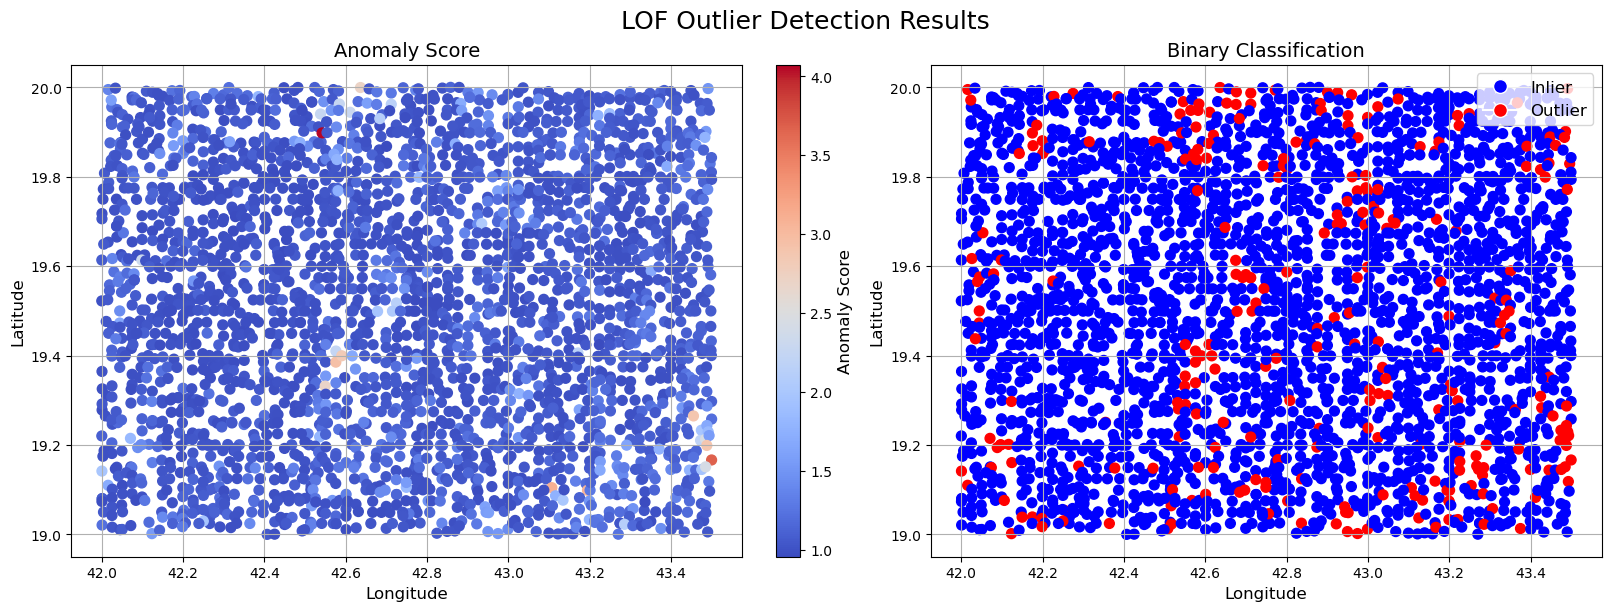

In [9]:
# Plotting LOF results
plot_outlier_results(
    data=LOF_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="LOF Outlier Detection Results",
)

Remember that higher LOF scores indicate a *higher likelihood of being anomalous.*
<br />
<br />

---

### <u>Angle Based Outlier Detection</u>

Our final method of outlier detection is angle based outlier detection. This method compares the distribution of angles of distance vectors between a sample point and its neighbors; a point with a large distribution of vector angles is considered an inlier (within a cluster), while a point with a smaller distribution of angles is likely an outlier (outside a cluster). An angle-based score is then calculated, with less variation indicating a higher probability of the sample point being an outlier. One benefit of ABOD is that it is free of any parameters, and thus does not have the potential prediction variability resulting from tuning. Its implementation does not, however, output a binary classification, thus in order to generate one an arbitrary threshold must be defined. 

In [16]:
def ABOD(
    data: pd.DataFrame, feature_columns: list = None, scale_data: bool = False
) -> pd.DataFrame:
    """
    Optimized Angle-Based Outlier Detection (ABOD) for geochemical datasets.

    Parameters:
    - data (pd.DataFrame): Input dataset.
    - feature_columns (list): Columns to use for features (default: all numerical columns).
    - scale_data (bool): Whether to scale features using StandardScaler (default: False).

    Returns:
    - pd.DataFrame: Input dataset with an additional column 'anomaly_score'.
    """
    # Make a copy of the dataset to avoid modifying the original
    data_copy = data.copy()

    # Use all numerical columns if no feature columns are provided
    if feature_columns is None:
        feature_columns = data_copy.select_dtypes(include=[np.number]).columns.tolist()
        if not feature_columns:
            raise ValueError("No numerical columns found to use as features.")

    # Extract features and handle missing values
    features = (
        data_copy[feature_columns].fillna(data_copy[feature_columns].median()).values
    )

    # Apply feature scaling if enabled
    if scale_data:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

    n_samples = features.shape[0]
    abod_scores = np.zeros(n_samples)

    for query_index in range(n_samples):
        # Extract the query point
        A = features[query_index]

        # Compute pairwise vectors relative to A
        T = np.delete(features, query_index, axis=0)  # Exclude the query point
        vectors = T - A

        # Compute pairwise norms and dot products
        norms = np.linalg.norm(vectors, axis=1)
        valid_indices = norms > 0  # Avoid zero norms (self-pairs)
        vectors = vectors[valid_indices]
        norms = norms[valid_indices]

        # Normalize vectors by their norms
        unit_vectors = vectors / norms[:, None]

        # Compute dot products for all pairwise combinations
        dot_products = np.dot(unit_vectors, unit_vectors.T)

        # Compute the weights (1 / norm products)
        norm_products = np.outer(norms, norms)
        weights = 1 / norm_products

        # Compute weighted contributions
        weighted_dot_products = dot_products * weights
        weighted_squared_contributions = weighted_dot_products**2

        # Compute variance of weighted contributions
        weight_sum = np.sum(weights)
        if weight_sum == 0:
            abod_scores[query_index] = float("inf")
        else:
            weighted_mean_squared = np.sum(weighted_squared_contributions) / weight_sum
            weighted_mean = np.sum(weighted_dot_products) / weight_sum
            abod_scores[query_index] = weighted_mean_squared - (weighted_mean**2)

        # Print progress
        print(f"Computed ABOD score for point {query_index + 1} of {n_samples}      {round((query_index/n_samples)*100)}%", end="\r")

    # Add anomaly scores to the dataset
    data_copy["anomaly_score"] = abod_scores

    return data_copy

In [17]:
# Run the function
feature_columns = ['Br', 'Cl', 'Cr', 'Hf',
       'P', 'Rb', 'Ti', 'Zr', 'SiO2', 'Al2O3', 'TFe2O3', 'K2O', 'Ba', 'Mn',
       'Sr', 'V', 'Zn', 'MgO', 'CaO', 'Na2O', 'Be', 'Bi', 'Co', 'Cs', 'Cu',
       'Ga', 'In', 'Li', 'Mo', 'Nb', 'Ni', 'Tl', 'Te', 'Sc', 'Y', 'Ge', 'I',
       'Ta', 'W', 'Re', 'Au', 'Ir', 'Os', 'Pd', 'Pt', 'Rh', 'Ru', 'Sb', 'Se',
       'Ag', 'B', 'Sn', 'F', 'N', 'S', 'TC', 'LOI'] # List of all geochemical columns

ABOD_df= ABOD(
    df, feature_columns, scale_data=True
)

In [18]:
# Define the threshold (manually or based on a percentile)
threshold = ABOD_df["anomaly_score"].quantile(0.05)  # Bottom 5% of anomaly scores

# Add a binary 'outlier' column based on the threshold
ABOD_df["outlier"] = ABOD_df["anomaly_score"].apply(
    lambda x: -1 if x < threshold else 1
)

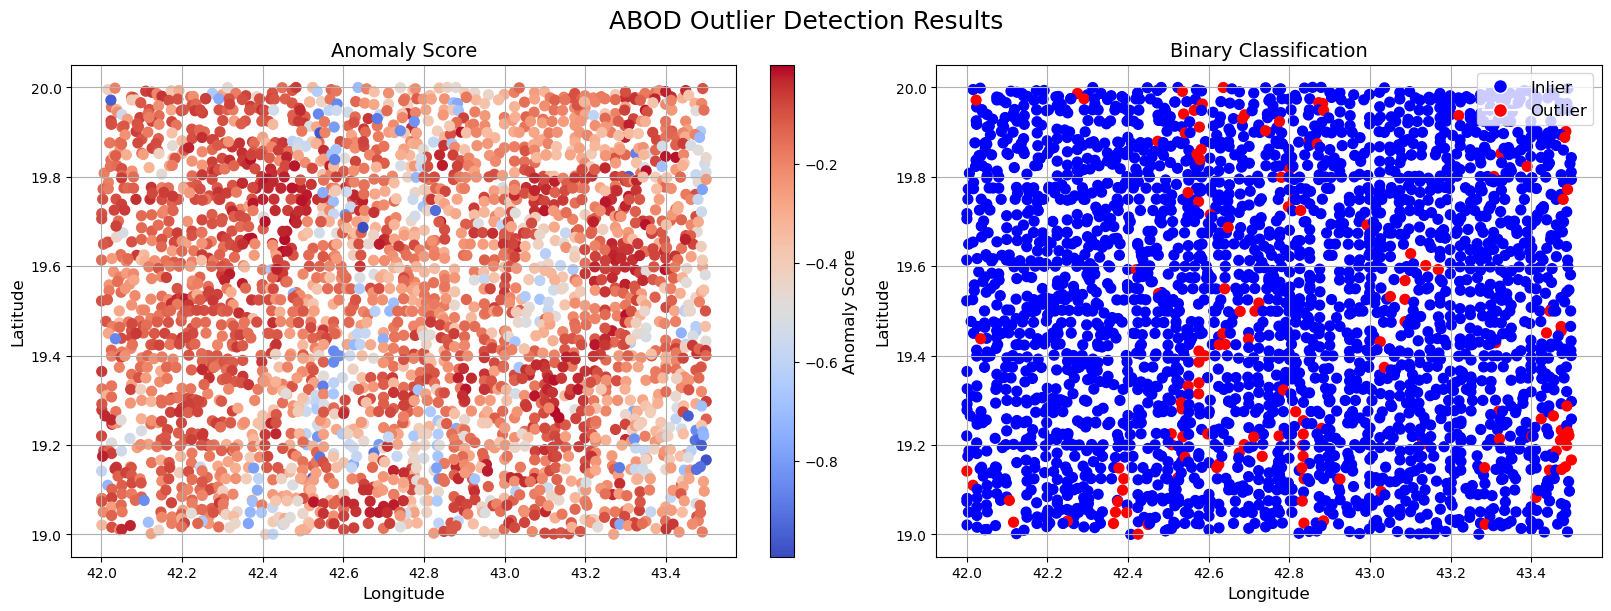

In [19]:
# Plotting LOF results
plot_outlier_results(
    data=ABOD_df,
    x_col="Longitude",
    y_col="Latitude",
    score_col="anomaly_score",
    binary_col="outlier",
    point_size=50,
    plot_title="ABOD Outlier Detection Results",
)

In [ ]:
# Unoptimized version of ABOD operation for comparison - DO NOT RUN
def ABOD_unoptimized(
    data: pd.DataFrame,
    feature_columns: list = None,
) -> pd.DataFrame:
    """
    Detect outliers in a geochemical dataset using the Angle-Based Outlier Detection (ABOD) algorithm.

    Parameters:
    - data (pd.DataFrame): The input geochemical dataset.
    - feature_columns (list): List of column names to be used as features.
                              If None, all numerical columns will be used.

    Returns:
    - pd.DataFrame: A DataFrame with an additional column:
        - 'anomaly_score': Continuous anomaly score (lower = more anomalous).
    """
    # Make a copy of the input DataFrame to avoid modifying the original
    data_copy = data.copy()

    # Validate inputs
    if not isinstance(data_copy, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")

    # Use all numerical columns if feature_columns is None
    if feature_columns is None:
        feature_columns = data_copy.select_dtypes(include=[np.number]).columns.tolist()
        if not feature_columns:
            raise ValueError(
                "No numerical columns found in the dataset to use as features."
            )

    if not all(col in data_copy.columns for col in feature_columns):
        raise ValueError("Some feature columns are not present in the dataset.")

    # Prepare the data
    features = data_copy[feature_columns].copy()

    # Handle missing values by imputing with column median
    if features.isnull().values.any():
        features = features.fillna(features.median())

    # Initialize the anomaly scores
    n_samples = features.shape[0]
    abod_scores = np.zeros(n_samples)

    # Calculate ABOD for all points
    for query_index in range(n_samples):
        # Extract query point A
        A = features.iloc[query_index].values

        # Create a copy of the dataset excluding the query point A
        T = features.drop(index=features.index[query_index]).values

        n = T.shape[0]
        weighted_a_squared_sum = 0.0
        weighted_a_sum = 0.0
        weight_sum = 0.0

        # Iterate over all pairs of points in T
        for i in range(n):
            for j in range(i + 1, n):
                # Points B and C
                B = T[i]
                C = T[j]

                # Compute vectors AB and AC
                AB = B - A
                AC = C - A

                # Compute dot product and norms
                dot_product = np.dot(AB, AC)
                norm_AB = np.linalg.norm(AB)
                norm_AC = np.linalg.norm(AC)

                # Avoid division by zero
                if norm_AB == 0 or norm_AC == 0:
                    continue

                # Normalize the dot product
                a = dot_product / (norm_AB**2 * norm_AC**2)

                # Compute the weighting factor
                w = 1 / (norm_AB * norm_AC)

                # Weighted contributions
                weighted_a = w * a
                weighted_a_squared = weighted_a**2

                # Update sums
                weighted_a_squared_sum += weighted_a_squared
                weighted_a_sum += weighted_a
                weight_sum += w

        # Compute weighted mean of squared contributions
        if weight_sum == 0:
            abod_scores[query_index] = float("inf")
        else:
            first_argument = weighted_a_squared_sum / weight_sum
            second_argument = (weighted_a_sum / weight_sum) ** 2
            variance = first_argument - second_argument
            abod_scores[query_index] = variance

        # Print progress
        print(f"Computed ABOD for point {query_index + 1} of {n_samples}", end="\r")

    # Add anomaly scores to the DataFrame
    data_copy["anomaly_score"] = abod_scores

    return data_copy

---

## <u>Validation of predictions</u>

Multivariate anomaly detection picks up on trends across multiple elements, rather than just single-element variation. As opposed to univariate anomalies that may be attributed to noise, sampling error, or highly-localized trends, multivariate analysis may point towards regions of broader geologic alteration related to mineral deposits. To test this relationship, we will compare outlier predictions from each model against known mineral occurrences in the sampling region. 

In [20]:
# Import validation dataset

validation_filepath = "/Users/thowe/MinersAI Dropbox/Tyler Howe/KSA Data/KSA_gsas_mineral_occurrences_clipped.geojson"

validation_gdf = gpd.read_file(validation_filepath)
validation_df = validation_gdf.copy()
validation_df['Longitude'] = validation_df['geometry'].x
validation_df['Latitude'] = validation_df['geometry'].y
validation_df.drop(columns='geometry', inplace=True)

### *Spatial validation of outlier predictions*

To start, we will conduct a visual analysis on the data, comparing binary outlier classifications vs. known mineral occurrences in the region.

In [21]:
def plot_validation(
    outlier_datasets: list,
    outlier_dataset_names: list, 
    validation_df: pd.DataFrame,
    x_col: str = "Longitude",
    y_col: str = "Latitude",
    binary_col: str = "outlier",
    point_size: float = 10,
    plot_title: str = "Outlier Detection Validation",
    colormap: str = "tab10",  # Changeable colormap
):

    # Get colormap and generate distinct colors
    cmap = plt.colormaps[colormap]
    colors = cmap(np.linspace(0, 1, len(outlier_datasets)))  # Generate distinct colors

    plt.figure(figsize=(10, 8))

    # Plot outlier datasets
    for i, (df, name) in enumerate(zip(outlier_datasets, outlier_dataset_names)):
        if binary_col not in df.columns:
            raise ValueError(f"Column '{binary_col}' not found in dataset {i+1}")

        # Filter only outliers (-1)
        outliers = df[df[binary_col] == -1]

        plt.scatter(
            outliers[x_col],
            outliers[y_col],
            c=[colors[i]],
            s=point_size,
            label = name,
            alpha=0.6,
            #edgecolor="black",
        )

    # Plot validation dataset as yellow stars
    plt.scatter(
        validation_df[x_col],
        validation_df[y_col],
        c="yellow",
        s=point_size * 30,  # Slightly larger for visibility
        marker="*",
        label="Known Mineral Occurrences",
        edgecolor="black",
    )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(plot_title, fontsize=14)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.grid(True)
    plt.show()

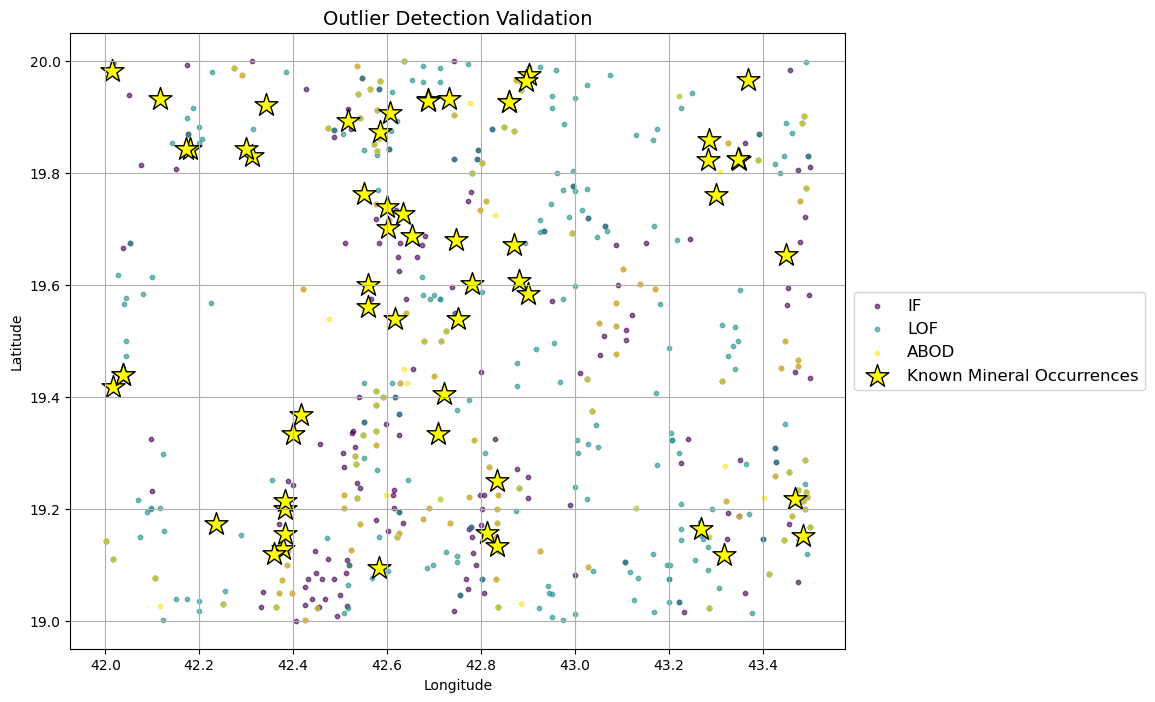

In [22]:
# Plot outlier detection results and validation dataset

outlier_results = [IF_df, LOF_df, ABOD_df]
outlier_result_names = ['IF', 'LOF', 'ABOD']

plot_validation(outlier_datasets=outlier_results, outlier_dataset_names=outlier_result_names, validation_df=validation_df, point_size=10, colormap='viridis')

---

### *ROC-AUC, ANOVA F-statistic, and Mutual Information scoring of outlier predictions*

To quantitatively compare the different outlier prediction methods, we will use three different scoring methods: ROC-AUC, ANOVA F-statistic, and Mutual Information.
<br />
<br />
- *<u>ROC-AUC, or Receiver Operating Characteristic Area Under the Curve</u>* is a machine learning metric used to evaluate a model's ability to distinguish between positive and negative classes; a score of 1 is considered 'perfect,' or that the model gets 100% of predictions correct. 
    - Generally best for evaluating overall predictive performance, regardless of spatial location.
<br />
<br />
- The *<u>ANOVA F-statistic</u>* is a method of comparing the variances of two samples (in this case the prediction and the validation set); the higher the score, the greater the model's predictions are differentiated. That is, there is a meaningful pattern between predicted outliers and known mineral deposits.
    - Measures how well the model distinguishes spatially relevant anomalies.
<br />
<br />
- *<u>Mutual Information</u>* is a method of measuring how much information one variable provides about another, or how dependent they are on each other. Higher MI values indicate stronger relationships between variables. 
    - Quantifies dependency between outlier predictions and proximity to known deposits.

In [29]:
def calculate_roc_auc(
    outlier_datasets,
    outlier_dataset_names,
    validation_df,
    x_col="Longitude",
    y_col="Latitude",
    prediction_col="anomaly_score",  # Now using continuous scores
    radius=0.01,
):
    """
    Computes the ROC-AUC score for each outlier detection method based on spatial proximity to known mineral occurrences.

    Parameters:
    - outlier_datasets (list): List of DataFrames containing outlier data.
    - outlier_dataset_names (list): Corresponding list of dataset names.
    - validation_df (pd.DataFrame): DataFrame with known mineral occurrences.
    - x_col (str): Column name for longitude.
    - y_col (str): Column name for latitude.
    - prediction_col (str): Column name for continuous anomaly scores.
    - radius (float): Search radius (in degrees, roughly 1° ≈ 111 km at the equator).

    Returns:
    - A dictionary mapping dataset names to their respective spatial ROC-AUC scores.
    """

    roc_auc_scores = {}

    # Create a KD-Tree for fast spatial lookup of validation points
    validation_tree = cKDTree(validation_df[[x_col, y_col]].values)

    for df, name in zip(outlier_datasets, outlier_dataset_names):
        if prediction_col not in df.columns:
            raise ValueError(f"Column '{prediction_col}' not found in dataset '{name}'")

        # Query nearest validation points within the radius
        distances, _ = validation_tree.query(
            df[[x_col, y_col]].values, distance_upper_bound=radius
        )

        # Label as '1' (positive) if the outlier is close to a known deposit, else '0' (negative)
        df["is_near_deposit"] = (distances != np.inf).astype(int)

        # Ensure we have both positive and negative samples
        if len(df["is_near_deposit"].unique()) < 2:
            print(
                f"Warning: Only one class present in '{name}' dataset. Skipping ROC-AUC."
            )
            continue

        # 🔹 Flip anomaly scores for IF & ABOD (since lower values indicate stronger anomalies)
        if name in ["IF", "ABOD"]:
            df[prediction_col] = -df[
                prediction_col
            ]  # Invert anomaly scores **before normalization**

        # 🔹 Normalize scores to ensure consistency across models
        min_val, max_val = df[prediction_col].min(), df[prediction_col].max()
        if max_val > min_val:  # Avoid division by zero
            df[prediction_col] = (df[prediction_col] - min_val) / (max_val - min_val)

        # Compute ROC-AUC score using continuous anomaly scores
        roc_auc = roc_auc_score(df["is_near_deposit"], df[prediction_col])
        roc_auc_scores[name] = roc_auc

        print(f"ROC-AUC Score for {name}: {roc_auc:.4f}")

    return roc_auc_scores

In [30]:
def calculate_f_score(
    outlier_datasets,
    outlier_dataset_names,
    validation_df,
    x_col="Longitude",
    y_col="Latitude",
    prediction_col="anomaly_score",  # Now using continuous predictions
    radius=0.01,
):
    """
    Computes the F-score (ANOVA F-statistic) for each outlier detection method based on spatial proximity to known mineral occurrences.

    Parameters:
    - outlier_datasets (list): List of DataFrames containing outlier data.
    - outlier_dataset_names (list): Corresponding list of dataset names.
    - validation_df (pd.DataFrame): DataFrame with known mineral occurrences.
    - x_col (str): Column name for longitude.
    - y_col (str): Column name for latitude.
    - prediction_col (str): Column name for continuous anomaly scores.
    - radius (float): Search radius (in degrees, roughly 1° ≈ 111 km at the equator).

    Returns:
    - A dictionary mapping dataset names to their respective spatial F-scores.
    """

    f_scores = {}

    # Create a KD-Tree for fast spatial lookup of validation points
    validation_tree = cKDTree(validation_df[[x_col, y_col]].values)

    for df, name in zip(outlier_datasets, outlier_dataset_names):
        if prediction_col not in df.columns:
            raise ValueError(f"Column '{prediction_col}' not found in dataset '{name}'")

        # Query nearest validation points within the radius
        distances, _ = validation_tree.query(
            df[[x_col, y_col]].values, distance_upper_bound=radius
        )

        # Label as '1' (positive) if the outlier is close to a known deposit, else '0' (negative)
        df["is_near_deposit"] = (distances != np.inf).astype(int)

        # 🔹 Flip anomaly scores for IF & ABOD (since lower values indicate stronger anomalies)
        if name in ["IF", "ABOD"]:
            df[prediction_col] = -df[
                prediction_col
            ]  # Flip scores **before** normalization

        # 🔹 Normalize scores to ensure consistency across models
        min_val, max_val = df[prediction_col].min(), df[prediction_col].max()
        if max_val > min_val:  # Avoid division by zero
            df[prediction_col] = (df[prediction_col] - min_val) / (max_val - min_val)

        # Split into two groups based on spatial proximity
        group_near = df[df["is_near_deposit"] == 1][prediction_col]
        group_far = df[df["is_near_deposit"] == 0][prediction_col]

        # Check if we have enough data points to perform ANOVA
        if len(group_near) < 2 or len(group_far) < 2:
            print(
                f"Warning: Not enough data points in both groups for '{name}'. Skipping F-score calculation."
            )
            continue

        # Compute F-score (ANOVA F-statistic)
        f_stat, _ = f_oneway(group_near, group_far)
        f_scores[name] = f_stat

        print(f"F-Score for {name}: {f_stat:.4f}")

    return f_scores

In [31]:
def calculate_mi_score(
    outlier_datasets,
    outlier_dataset_names,
    validation_df,
    x_col="Longitude",
    y_col="Latitude",
    binary_col="outlier",
    radius=0.01,
):
    """
    Computes the Mutual Information (MI) score for each outlier detection method
    based on spatial proximity to known mineral occurrences.

    Parameters:
    - outlier_datasets (list): List of DataFrames containing outlier data.
    - outlier_dataset_names (list): Corresponding list of dataset names.
    - validation_df (pd.DataFrame): DataFrame with known mineral occurrences.
    - x_col (str): Column name for longitude.
    - y_col (str): Column name for latitude.
    - binary_col (str): Column name for binary classification (-1 for outliers, 1 for inliers).
    - radius (float): Search radius (in degrees, roughly 1° ≈ 111 km at the equator).

    Returns:
    - A dictionary mapping dataset names to their respective Mutual Information scores.
    """

    mi_scores = {}

    # Create a KD-Tree for fast spatial lookup of validation points
    validation_tree = cKDTree(validation_df[[x_col, y_col]].values)

    for df, name in zip(outlier_datasets, outlier_dataset_names):
        if binary_col not in df.columns:
            raise ValueError(f"Column '{binary_col}' not found in dataset '{name}'")

        # Convert outlier labels (-1 -> 1 for outliers, 1 -> 0 for inliers)
        df["predicted_outlier"] = np.where(df[binary_col] == -1, 1, 0)

        # Query nearest validation points within the radius
        distances, _ = validation_tree.query(
            df[[x_col, y_col]].values, distance_upper_bound=radius
        )

        # Label as '1' (positive) if the outlier is close to a known deposit, else '0' (negative)
        df["is_near_deposit"] = (distances != np.inf).astype(int)

        # Compute Mutual Information (MI) between predicted outlier status and validation proximity
        mi_score = mutual_info_score(df["predicted_outlier"], df["is_near_deposit"])
        mi_scores[name] = mi_score

        print(f"Mutual Information Score for {name}: {mi_score:.4f}")

    return mi_scores

In [32]:
def plot_score_histograms(
        score_dicts, # List of output score dictionaries
        titles=None # Optional list of titles for each set
):

    num_sets = len(score_dicts)

    # Create figure with dynamic subplots if multiple sets exist
    fig, axes = plt.subplots(1, num_sets, figsize=(6 * num_sets, 5), sharey=False)

    if num_sets == 1:
        axes = [axes]  # Ensure it's iterable

    if titles is None:
        titles = [f"Score Set {i+1}" for i in range(num_sets)]

    for ax, scores, title in zip(axes, score_dicts, titles):
        # Sort scores from highest to lowest
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        methods, values = zip(*sorted_scores) if sorted_scores else ([], [])

        # x positions
        x_positions = np.arange(len(methods))  # Use integer spacing

        # Plot histogram
        ax.bar(x_positions, values, alpha=0.7, width=0.5, align="center")

        # Set individual ylim with 10% headroom
        if values:
            ylim_max = max(values) * 1.1
        else:
            ylim_max = 1  # Default limit if no values

        ax.set_ylim(0, ylim_max)

        # Formatting
        #ax.set_xlabel("Outlier Detection Methods")
        #ax.set_ylabel("Score")  # Ensure all plots have y-labels
        ax.set_title(title)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(methods, rotation=45, ha="right")
        ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

ROC-AUC Score for IF: 0.6980
ROC-AUC Score for LOF: 0.6475
ROC-AUC Score for ABOD: 0.7579
F-Score for IF: 30.6217
F-Score for LOF: 10.8421
F-Score for ABOD: 35.8927
Mutual Information Score for IF: 0.0019
Mutual Information Score for LOF: 0.0008
Mutual Information Score for ABOD: 0.0026


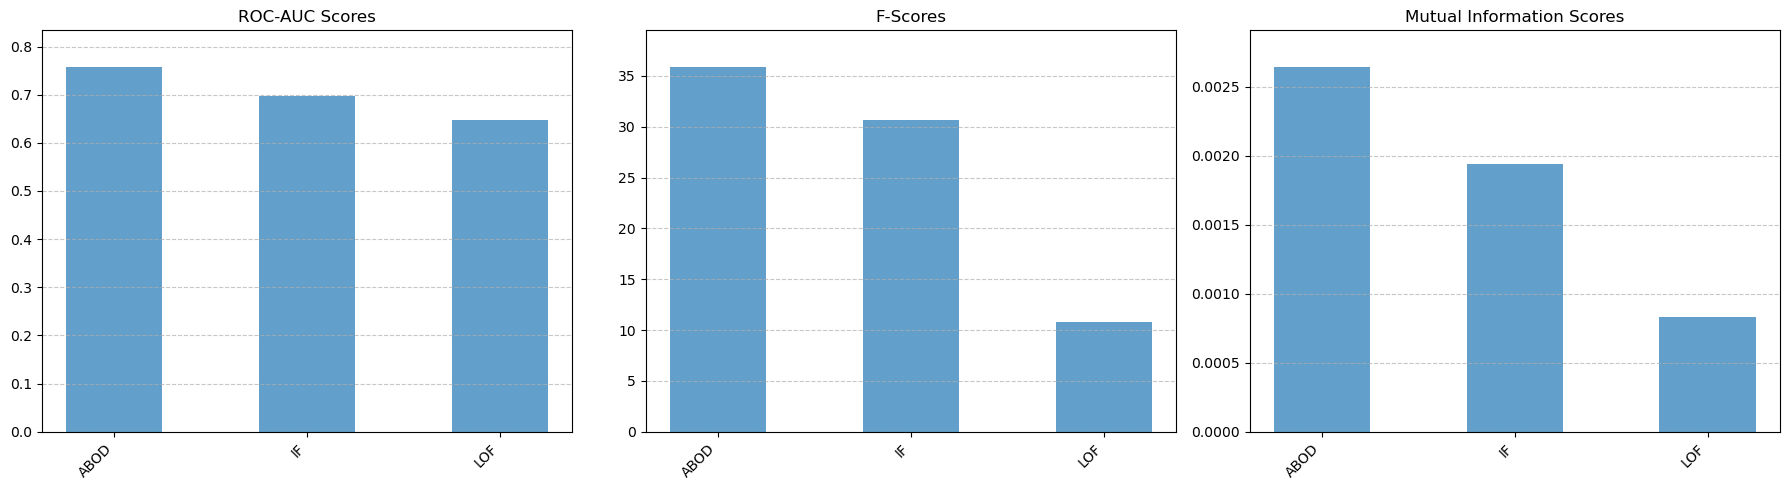

In [33]:
# Calculate scores for each outlier detection method
# rad 0.005 ~=500m

scoring_radius = 0.005 # roughly 500m

roc_auc_scores = calculate_roc_auc(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
) 

f_scores = calculate_f_score(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
)

mi_scores = calculate_mi_score(
    outlier_results, outlier_result_names, validation_df, radius=scoring_radius
)

plot_score_histograms([roc_auc_scores, f_scores, mi_scores], titles=["ROC-AUC Scores", "F-Scores", "Mutual Information Scores"])

---

### *Deeper investigation into ROC-AUC scoring of each model*

Since the ROC-AUC scores for each model above are so similar, let's create a ROC curve to better understand the model performance. 

In [34]:
def plot_roc_curves(
    outlier_datasets,
    outlier_dataset_names,
    validation_df,
    x_col="Longitude",
    y_col="Latitude",
    prediction_col="anomaly_score",
    radius=0.01,
):
    """
    Computes and plots the ROC curves for multiple outlier detection methods
    based on spatial proximity to known mineral occurrences.

    Parameters:
    - outlier_datasets (list): List of DataFrames containing outlier data.
    - outlier_dataset_names (list): Corresponding list of dataset names.
    - validation_df (pd.DataFrame): DataFrame with known mineral occurrences.
    - x_col (str): Column name for longitude.
    - y_col (str): Column name for latitude.
    - prediction_col (str): Column name for anomaly scores (continuous values).
    - radius (float): Search radius (in degrees, roughly 1° ≈ 111 km at the equator).
    """

    plt.figure(figsize=(8, 6))  # Set figure size

    # Create a KD-Tree for fast spatial lookup of validation points
    validation_tree = cKDTree(validation_df[[x_col, y_col]].values)

    for df, name in zip(outlier_datasets, outlier_dataset_names):
        if prediction_col not in df.columns:
            raise ValueError(f"Column '{prediction_col}' not found in dataset '{name}'")

        # Query nearest validation points within the radius
        distances, _ = validation_tree.query(
            df[[x_col, y_col]].values, distance_upper_bound=radius
        )

        # Label as '1' (positive) if the outlier is close to a known deposit, else '0' (negative)
        df["is_near_deposit"] = (distances != np.inf).astype(int)

        # Ensure we have both positive and negative samples
        if len(df["is_near_deposit"].unique()) < 2:
            print(
                f"Warning: Only one class present in '{name}' dataset. Skipping ROC curve."
            )
            continue

        # 🔹 Flip scores for IF & ABOD (lower scores indicate stronger anomalies)
        if name in ["IF", "ABOD"]:
            df[prediction_col] = -df[prediction_col]  # Invert anomaly scores

        # 🔹 Normalize scores to ensure consistency
        df[prediction_col] = (df[prediction_col] - df[prediction_col].min()) / (
            df[prediction_col].max() - df[prediction_col].min()
        )

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(df["is_near_deposit"], df[prediction_col])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

    # Plot diagonal reference line (random classifier)
    plt.plot(
        [0, 1], [0, 1], color="gray", linestyle="--", lw=2, label="Random Classifier"
    )

    # Formatting
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Outlier Detection Models")
    plt.legend(loc="lower right")
    plt.grid(True)

    # Show the plot
    plt.show()

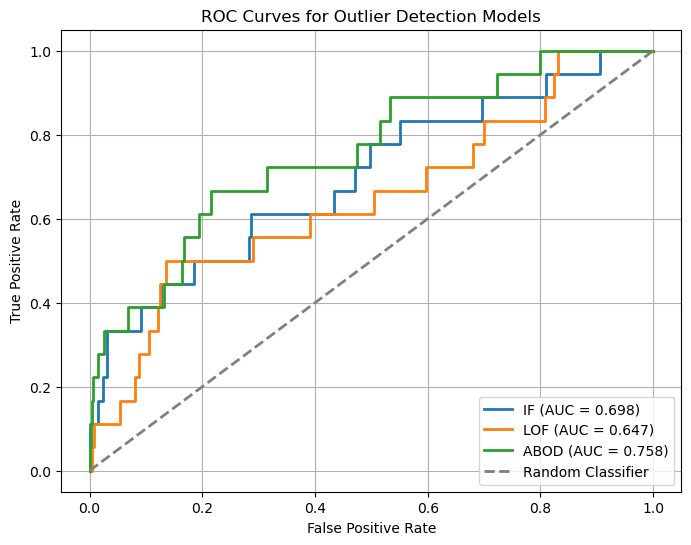

In [35]:
plot_roc_curves(
    outlier_datasets=outlier_results,  # Your outlier model DataFrames
    outlier_dataset_names=outlier_result_names,  # Names of models
    validation_df=validation_df,  # Known mineral deposits
    radius=scoring_radius,  # Search radius
)